In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input

# Préparation des échantillons

In [2]:
def data_transformation(df):
    data = df.T
    data["path_to_image"]="../raw_data/IMG/"+data["image_name"]
    data['species'] = data['genus']+' '+data['specific_epithet'] 
    return data

In [3]:
def X_y_from_df(df, sample_size):
    data_sample = df.sample(sample_size, random_state = 818)
    image = []

    for i in data_sample['path_to_image'] :
        img = Image.open(i)
        img = img.resize((128,128))
        image.append(np.array(img))

    X = np.array(image)
    y = np.array(data_sample['species'])
    return X, y

In [4]:
df_train = data_transformation(pd.read_json('../raw_data/splits/train.json'))
df_val = data_transformation(pd.read_json('../raw_data/splits/val.json'))
df_test = data_transformation(pd.read_json('../raw_data/splits/test.json'))

In [5]:
def filter_df(df):
    df.query('country == ["Switzerland","France", "Italy", "Germany"]', inplace=True)
    df['nb_images_specy'] = df.groupby('species')['species'].transform('count')
    df.query('nb_images_specy > 4', inplace=True)
    return df

In [6]:
df_val.shape

(5017, 17)

In [7]:
df_val = filter_df(df_val)
df_train = filter_df(df_train)
df_test = filter_df(df_test)

In [8]:
df_val.shape

(3788, 18)

In [9]:
X_val, y_val = X_y_from_df(df_val, 100)
X_test, y_test = X_y_from_df(df_test, 100)
X_train, y_train = X_y_from_df(df_train, 500)

y_train = y_train.reshape(500, 1)
y_val = y_val.reshape(100, 1)
y_test = y_test.reshape(100, 1)


X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


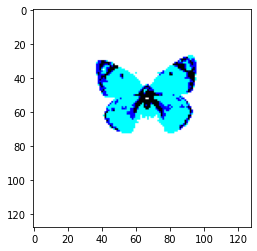

In [10]:
plt.imshow(X_train[1])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


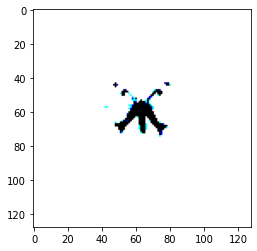

In [13]:
plt.imshow(X_train[50])
plt.show()

In [14]:
type(X_train[50])

numpy.ndarray

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (2643007023.py, line 1)

In [16]:
ef load_image(path):
    with open(path, 'rb') as f:
        data = f.read()
    encoded = base64.b64encode(data).decode()
    return encoded



ValueError: a must be greater than 0 unless no samples are taken

In [ ]:
plt.imshow(X_train[1][:,:,::-1])
plt.show()

In [ ]:
X_train[0]

In [ ]:
X_train.shape, X_test.shape, X_val.shape

In [ ]:
y_train.shape, y_test.shape, y_val.shape

In [ ]:
pd.DataFrame(y_train).drop_duplicates()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False, handle_unknown = 'ignore')
ohe.fit(y_train)
y_train_cat = ohe.transform(y_train)
y_val_cat = ohe.transform(y_val)
y_test_cat = ohe.transform(y_test)

# Lancement du modèle

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import optimizers, layers, models
from tensorflow.keras.callbacks import EarlyStopping


def model_VGG16( X_train, y_train_cat, X_val, y_val_cat, X_test, y_test_cat, image_size,  patience=2, learning_rate=0.001, nb_epochs=15, nb_couches_dense_layer=130):
    
    model = VGG16(weights="imagenet", include_top=False, input_shape = image_size)
    # Set the first layers to be untrainable
    model.trainable = False
    
    #add last layers
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(nb_couches_dense_layer, activation='relu')
    prediction_layer = layers.Dense(170, activation='softmax')
    model = models.Sequential([
        model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])
    
    #build model
    opt = optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    #set earlystopping
    es = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)
    
    #launch model
    history = model.fit(X_train, y_train_cat, 
                    validation_data=(X_val, y_val_cat), 
                    epochs=nb_epochs, 
                    batch_size=32, 
                    callbacks=[es])
    
    #evaluate model
    res_vgg = model.evaluate(X_test, y_test_cat)
    
    test_accuracy_vgg = res_vgg[-1]
    
    return (f"test_accuracy_vgg = {round(test_accuracy_vgg,2)*100} %"), history

In [ ]:
model, history = model_VGG16( X_train, y_train_cat, X_val, y_val_cat, X_test, y_test_cat, image_size= X_train[0].shape,  patience=3, learning_rate=0.001, nb_epochs=30, nb_couches_dense_layer=130)
plot_history(history)

# Courbes d'apprentissage

In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [ ]:
pwd


In [ ]:
from tensorflow.keras.models import load_model
model.save("../raw_data/models/model_14_VGG16_128_prunelle")

# Historique

In [ ]:
plt.imshow(X_train[0])

In [ ]:
X_train[0].shape

In [ ]:
model_VGG16(X_train, y_train_cat, X_val, y_val_cat, X_test, y_test_cat, X_train[0].shape, 5, 0.001, 15, 130)

In [ ]:
model = load_model()
model.summary()

In [ ]:
def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False
    
    return model

model
model = set_nontrainable_layers(model)

model.summary()

In [ ]:
from tensorflow.keras import layers, models

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainables, and add additional trainable layers on top'''
    # $CHALLENGIFY_BEGIN
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(130, activation='relu')
    prediction_layer = layers.Dense(248, activation='softmax')
    
    
    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])
    # $CHALLENGIFY_END
    return model

In [ ]:
model = add_last_layers(model)
model.summary()

In [ ]:
from tensorflow.keras import optimizers

def build_model():
    # $CHALLENGIFY_BEGIN    
    model = load_model()
    model = add_last_layers(model)
    
    opt = optimizers.Adam(learning_rate=1e-3)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model
    # $CHALLENGIFY_END

In [ ]:
model = build_model()

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

def load_model():
    # $CHALLENGIFY_BEGIN
    model = VGG16(weights="imagenet", include_top=False, input_shape=image[0].shape)
    # $CHALLENGIFY_END
    
    return model

In [ ]:
X_train.shape

In [ ]:
X_val.shape

In [ ]:
y_train

In [ ]:
y_train.shape

In [ ]:
y_val.shape

In [ ]:
y_cat.shape

In [ ]:
y_val_cat.shape

In [ ]:
X_train.shape

In [ ]:
X_val.shape

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='max', patience=2, verbose=1, restore_best_weights=True)

history = model.fit(X_train, y_cat, 
                    validation_data=(X_val, y_val_cat), 
                    epochs=20, 
                    batch_size=16, 
                    callbacks=[es])

In [ ]:
res_vgg = model.evaluate(X_test, y_test_cat)

test_accuracy_vgg = res_vgg[-1]

print(f"test_accuracy_vgg = {round(test_accuracy_vgg,2)*100} %")

## tests photos API / encoding b64

In [ ]:
type(X_train[0])